# Assignment 2. Quantization for CNN

## Goals

본 실습에서는 CNN(Convolutional Neural Network)을 **양자화(Quantization)**하여 모델의 크기와 실행 시간을 줄이는 방법을 실습합니다.

## Contents
1. **Uniform Quantization**
  - **Linear quantization**을 구현하고 적용합니다.
  - **Linear quantization**을 위한 **Integer-only inference**를 구현하고 적용합니다.
2. **Non-uniform Quantization**
  - **K-means quantization**을 구현하고 적용합니다.
3. **Quantization with PyTorch API**
  - **Post-Training Quantization** (PTQ)
  - **Quantization-Aware Training** (QAT)

## Setup

먼저, 필요한 패키지를 설치하고 데이터셋과 사전 학습된 모델을 다운로드합니다. 여기서는 CIFAR10 데이터셋과 VGG 네트워크를 사용할 것입니다.

In [ ]:
import subprocess

print('Installing torchprofile...')
subprocess.check_call(["pip", "install", "torchprofile"])
print('Installing fast-pytorch-kmeans...')
subprocess.check_call(["pip", "install", "fast-pytorch-kmeans"])
print('All required packages have been successfully installed!')

In [ ]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))
    add("avgpool", nn.AvgPool2d(2))
    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    # x = x.mean([2, 3])
    x = x.view(x.shape[0], -1)

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# CIFAR-10 데이터셋 로드 및 전처리
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])]
)
trainset = torchvision.datasets.CIFAR10(
    root="D:\\data", train=True, download=True, transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root="D:\\data", train=False, download=True, transform=transform
)

trainloader = DataLoader(trainset, batch_size=1024, shuffle=True)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

# 모델 학습 함수 정의
def train_model(model, trainloader, epochs=5):
    try:
        device = next(model.parameters()).device
    except StopIteration:
        try:
            device = next(model.buffers()).device
        except StopIteration:
            # 파라미터나 버퍼가 모두 없으면 기본적으로 CPU로 설정
            device = torch.device("cpu")
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}")
    return model

# 모델 평가 함수 정의
def evaluate_model(model, testloader):
    try:
        device = next(model.parameters()).device
    except StopIteration:
        try:
            device = next(model.buffers()).device
        except StopIteration:
            # 파라미터나 버퍼가 모두 없으면 기본적으로 CPU로 설정
            device = torch.device("cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # Move the data from CPU to GPU
    if torch.cuda.is_available():
      inputs = inputs.cuda()
      targets = targets.cuda()
    if extra_preprocess is not None:
        for preprocess in extra_preprocess:
            inputs = preprocess(inputs)

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helpler Functions (Flops, Model Size calculation, etc.)

In [ ]:
def get_model_flops(model, inputs):
    num_macs = profile_macs(model, inputs)
    return num_macs

In [ ]:
def get_model_size(model: nn.Module, data_width=32):
    """
    calculate the model size in bits
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc funcions for verification.

Load Pretrained Model

In [ ]:
!curl -L "https://www.dropbox.com/scl/fi/ui1fkdvwlhd55fncto8fa/vgg_cifar10_pretrained.pth?rlkey=gu58eq42mo9riot1mexijw79k&st=gak0oq04&dl=1" -o "D:\\data\\vgg_cifar10_pretrained.pth"
checkpoint = torch.load('D:\\data\\vgg_cifar10_pretrained.pth', map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint 'vgg_cifar10_pretrained.pth'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda : model.load_state_dict(checkpoint['state_dict'])

#TORCH_HUB_REPO = "SKKU-ESLAB/pytorch-models"
#MODEL_NAME = "cifar10_vgg9_bn" # cifar10_resnet20, cifar10_vgg11_bn
#
#model = torch.hub.load(TORCH_HUB_REPO, MODEL_NAME, pretrained=True)
#if torch.cuda.is_available():
#    model = model.cuda()

In [ ]:
from torch.utils.data import Subset
import numpy as np

image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}

dataset = {}
for split in ["train", "test"]:
    dataset[split] = CIFAR10(
        root="D:\\data\\cifar10",
        train=(split == "train"),
        download=True,
        transform=transforms[split],
    )


num_classes = 10
targets = np.array(dataset['test'].targets)

indices = []
for class_idx in range(num_classes):
    class_indices = np.where(targets == class_idx)[0]
    selected_indices = np.random.choice(class_indices, len(class_indices) // 100, replace=False)
    indices.extend(selected_indices)

dataset['test'] = Subset(dataset['test'], indices)

dataloader = {}
for split in ['train', 'test']:
    dataloader[split] = DataLoader(
        dataset[split],
        batch_size=512,
        shuffle=(split == 'train'),
        num_workers=0,
        pin_memory=True,
    )

In [ ]:
def qconfig_printer(qconfig):
    # 가중치(weight) 관찰자 인스턴스 생성 및 속성 조회
    weight_observer_instance = qconfig.weight()
    weight_observer = weight_observer_instance.__class__.__name__
    weight_dtype = weight_observer_instance.dtype
    weight_qscheme = weight_observer_instance.qscheme
    weight_quant_min = weight_observer_instance.quant_min
    weight_quant_max = weight_observer_instance.quant_max

    # 활성화(activation) 관찰자 인스턴스 생성 및 속성 조회
    activation_observer_instance = qconfig.activation()
    activation_observer = activation_observer_instance.__class__.__name__
    activation_dtype = activation_observer_instance.dtype
    activation_qscheme = activation_observer_instance.qscheme
    activation_quant_min = activation_observer_instance.quant_min
    activation_quant_max = activation_observer_instance.quant_max


    # 결과 출력
    print(f"Weight Observer: {weight_observer}")
    print(f"Weight dtype: {weight_dtype}")
    print(f"Weight qscheme: {weight_qscheme}")
    print(f"Weight quant_min: {weight_quant_min}")
    print(f"Weight quant_max: {weight_quant_max}")
    print("----------------------------------------------")
    print(f"Activation Observer: {activation_observer}")
    print(f"Activation dtype: {activation_dtype}")
    print(f"Activation qscheme: {activation_qscheme}")
    print(f"Activation quant_min: {activation_quant_min}")
    print(f"Activation quant_max: {activation_quant_max}")

# 2.1. Linear Quantization

이 섹션에서는 linear quantization을 구현하고 수행할 것입니다.

Linear quantization은 range truncation 및 scaling 후에 부동 소수점 실수값을 가장 가까운 정수로 반올림합니다.

[Linear quantization](https://arxiv.org/pdf/1712.05877.pdf) 은 다음과 같이 표현할 수 있습니다:

$r = S(q-Z)$

여기서 $r$ 과 $S$은 부동 소수점 실수이며, $q$ 와 $Z$ 는 *n*-bit 정수입니다. $Z$ 는 quantization zero point를 의미하며, $S$ 는 quantization scaling factor입니다. 상수 $Z$ 와 $S$ 는 quantization parameter 입니다.

먼저 FP32(32비트 부동 소수점) 모델의 정확도와 모델 크기를 평가해봅시다.

In [ ]:
fp32_model_accuracy = evaluate(model, dataloader['test'])
fp32_model_size = get_model_size(model)
print(f"fp32 model의 정확도={fp32_model_accuracy:.2f}%")
print(f"fp32 model의 크기={fp32_model_size/MiB:.2f} MiB")

## *n*-bit integer

*n*-bit signed integer 는 일반적으로 [2의 보수](https://ko.wikipedia.org/wiki/2%EC%9D%98_%EB%B3%B4%EC%88%98)로 표현됩니다.

*n*-bit signed integer는 정수 범위 $[-2^{n-1}, 2^{n-1}-1]$를 인코딩할 수 있습니다. 예를 들어, 8-bit integer는 범위 [-128, 127] 에 해당합니다.

In [ ]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

## [실습 1] Linear quantization 구현

다음 linear quantization 함수를 완성해 주세요.

**Hint**:
*   $r=S(q-Z)$ 로 부터, $q = r/S + Z$ 를 도출할 수 있습니다.
*   $r$ 과 $S$ 는 모두 부동 소수점이므로, 정수 $Z$ 을 부동 소수점 $r/S$ 에 직접 더할 수 없습니다. 그러므로 $q = \mathrm{int}(\mathrm{round}(r/S)) + Z$ 와 같이 계산해야 합니다.
*   [`torch.FloatTensor`](https://pytorch.org/docs/stable/tensors.html) 에서 [`torch.IntTensor`](https://pytorch.org/docs/stable/tensors.html) 로 변환하려면, 먼저 [`torch.round()`](https://pytorch.org/docs/stable/generated/torch.round.html#torch.round), [`torch.Tensor.round()`](https://pytorch.org/docs/stable/generated/torch.Tensor.round.html#torch.Tensor.round), 또는 [`torch.Tensor.round_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.round_)을 사용하여 모든 값을 부동 소수점 정수로 반올림 한 후, [`torch.Tensor.to(torch.int8)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch.Tensor.to) 를 사용하여 데이터 유형을 [`torch.float`](https://pytorch.org/docs/stable/tensors.html) 에서 [`torch.int8`](https://pytorch.org/docs/stable/tensors.html)로 변환해야 합니다.



In [ ]:
def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    linear quantization for single fp_tensor
      from
        fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    ############### YOUR CODE STARTS HERE ###############
    # Step 1: fp_tensor를 scale 하세요.
    scaled_tensor = fp_tensor/scale
    # Step 2: 부동 소수점 값을 정수 값으로 rounding 하세요.
    rounded_tensor = torch.round(scaled_tensor)
    ############### YOUR CODE ENDS HERE #################

    rounded_tensor = rounded_tensor.to(dtype)

    ############### YOUR CODE STARTS HERE ###############
    # Step 3: rounded_tensor를 zero_point 만큼 shift하여 영점을 조정합니다.
    shifted_tensor = rounded_tensor + zero_point
    ############### YOUR CODE ENDS HERE #################

    # Step 4: shifted_tensor를 bitwidth 범위에 있도록 절사(clamp)합니다.
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor

정의된 linear quantization 함수의 기능을 확인하기 위해 더미 텐서에 위의 함수를 적용해 보겠습니다.

In [ ]:
def test_linear_quantize(
    test_tensor=torch.tensor([
        [ 0.0523,  0.6364, -0.0968, -0.0020,  0.1940],
        [ 0.7500,  0.5507,  0.6188, -0.1734,  0.4677],
        [-0.0669,  0.3836,  0.4297,  0.6267, -0.0695],
        [ 0.1536, -0.0038,  0.6075,  0.6817,  0.0601],
        [ 0.6446, -0.2500,  0.5376, -0.2226,  0.2333]]),
    quantized_test_tensor=torch.tensor([
        [-1,  1, -1, -1,  0],
        [ 1,  1,  1, -2,  0],
        [-1,  0,  0,  1, -1],
        [-1, -1,  1,  1, -1],
        [ 1, -2,  1, -2,  0]], dtype=torch.int8),
    real_min=-0.25, real_max=0.75, bitwidth=2, scale=1/3, zero_point=-1):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fig, axes = plt.subplots(1,3, figsize=(10, 32))
    plot_matrix(test_tensor, axes[0], 'original tensor', vmin=real_min, vmax=real_max)
    _quantized_test_tensor = linear_quantize(
        test_tensor, bitwidth=bitwidth, scale=scale, zero_point=zero_point)
    _reconstructed_test_tensor = scale * (_quantized_test_tensor.float() - zero_point)
    print('* Test linear_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        scale: {scale}')
    print(f'        zero point: {zero_point}')
    assert _quantized_test_tensor.equal(quantized_test_tensor)
    print('* Test passed.')
    plot_matrix(_quantized_test_tensor, axes[1], f'2-bit linear quantized tensor',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(_reconstructed_test_tensor, axes[2], f'reconstructed tensor',
                vmin=real_min, vmax=real_max, cmap='tab20c')
    fig.tight_layout()
    plt.show()

In [ ]:
test_linear_quantize()

이제 linear quantization을 위한 scaling factor $S$ 와 zero point $Z$ 을 결정해야 합니다.

[Linear quantization](https://arxiv.org/pdf/1712.05877.pdf) 은 다음과 같이 표현될 수 있습니다:

$r = S(q-Z)$

### Scale

Linear quantization은 floating point range [*fp_min*, *fp_max*] 를 quantized range [*quantized_min*, *quantized_max*] 로 매핑합니다. 즉, 다음과 같이 표현할 수 있습니다:

> $r_{\mathrm{max}} = S(q_{\mathrm{max}}-Z)$
>
> $r_{\mathrm{min}} = S(q_{\mathrm{min}}-Z)$

이 두 방정식을 빼면, $S=(r_{\mathrm{max}} - r_{\mathrm{min}}) / (q_{\mathrm{max}} - q_{\mathrm{min}})$ 를 얻을 수 있습니다.


부동 소수점 텐서 `fp_tensor`의 $r_{\mathrm{min}}$ and  $r_{\mathrm{max}}$ 를 결정하는 데는 여러가지 접근 방법이 있습니다.

*  가장 일반적인 방법은 `fp_tensor`의 최소값과 최대값을 직접 사용하는 것입니다.
*  또 다른 방법은 쿨백-라이블러 발산(Kullback-Leibler-J divergence)을 최소화하여 *fp_max*를 결정하는 것입니다.

### zero point

Scaling factor $S$ 를 결정한 후, $r_{\mathrm{min}}$ 과 $q_{\mathrm{min}}$ 의 관계를 직접 사용하여 zero point $Z$ 를 계산할 수 있습니다.

> $Z = \mathrm{int}(\mathrm{round}(q_{\mathrm{min}} - r_{\mathrm{min}} / S))$

# [실습 2] Scale 및 zero point 계산

부동 소수점 텐서 $r$ 에서 scale $S$ 와 zero point $Z$ 을 계산하는 다음 함수를 완성해 주세요.

In [ ]:
def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    get quantization scale for single tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max().item()
    fp_min = fp_tensor.min().item()

    ############### YOUR CODE STARTS HERE ###############
    # hint: quantized_max - quantized_min = 2 ** bitwith - 1
    scale = (fp_max - fp_min) / (quantized_max - quantized_min)
    zero_point = round(quantized_min - fp_min/scale)
    ############### YOUR CODE ENDS HERE #################

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else: # convert from float to int using round()
        zero_point = round(zero_point)
    return scale, int(zero_point)

이제  실습 1의 `linear_quantize()`과 실습 2의 `get_quantization_scale_and_zero_point()`을 하나의 함수로 래핑합니다.

In [ ]:
def linear_quantize_feature(fp_tensor, bitwidth):
    """
    linear quantization for feature tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating feature to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [float] scale tensor
        [int] zero point
    """
    scale, zero_point = get_quantization_scale_and_zero_point(fp_tensor, bitwidth)
    quantized_tensor = linear_quantize(fp_tensor, bitwidth, scale, zero_point)
    return quantized_tensor, scale, zero_point

## 특수 케이스 : 가중치 텐서의 Linear quantization

먼저 가중치 텐서의 분포를 살펴보겠습니다.

In [ ]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

recover_model()
plot_weight_distribution(model)

위의 히스토그램에서 볼 수 있듯이, 가중치 값의 분포는 0을 중심으로 거의 대칭입니다(Classifier 제외).

따라서 일반적으로 가중치를 quantization 할 때 zeropoint $Z$를 0으로 설정합니다.

$r = S(q-Z)$ 로 부터, 우리는 다음을 도출 할 수 있습니다:

> $r_{\mathrm{max}} = S \cdot q_{\mathrm{max}}$

그러므로

> $S = r_{\mathrm{max}} / q_{\mathrm{max}}$

가중치 값의 최대 크기를 $r_{\mathrm{max}}$로 직접 사용합니다.

In [ ]:
def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # 가중치 텐서의 분포가 대칭이라고 가정합니다.
    # zeropoint를 0으로 설정합니다.
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max

### Per-tensor Linear Quantization

먼저 가장 기초적인 방법인 Per-Tensor Quantization을 적용해보겠습니다.

Per-Tensor Quantization은 weight tensor $W$ 에 대해서 하나의 scaling factors $S$ 와 zero points $Z$를 결정합니다.

Per-Tensor Quantization은 구현이 쉽고 연산량이 적으며, 크기가 큰 모델에서 잘 작동합니다.

In [ ]:
def linear_quantize_weight_per_tensor(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    scale_value = get_quantization_scale_for_weight(tensor, bitwidth)

    scale = torch.tensor([scale_value], device=tensor.device)

    scale_shape = [1] * tensor.dim()
    scale_shape[0] = tensor.shape[0]
    scale_per_channel = scale.expand(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale_per_channel, zero_point=0)

    return quantized_tensor, scale_per_channel, 0

### Per-channel Linear Quantization

2D convolution의 경우, 가중치 텐서는 (num_output_channels, num_input_channels, kernel_height, kernel_width) 형태의 4D tensor 입니다.

최근 연구에서는, 서로 다른 출력 채널에 대해 다른 scaling factors $S$ 와 zero points $Z$ 를 사용하는 것이 더 나은 성능을 발휘한다는 것을 보여줍니다.

따라서 각 출력 채널의 부분 텐서에 대한 scaling factor $S$ 와 zero point $Z$ 을 독립적으로 결정해야 합니다.

In [ ]:
def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)

    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

이제 서로 4-bit 비트 폭으로 가중치에 per-tensor와 per-channel linear quantization을 각각 적용할 때의 가중치 분포를 살펴보겠습니다.

In [ ]:
@torch.no_grad()
def peek_linear_quantization_per_tensor():
    for bitwidth in [4]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_tensor(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)
        recover_model()
print("Per-Tensor Quantization:")
peek_linear_quantization_per_tensor()

@torch.no_grad()
def peek_linear_quantization_per_channel():
    for bitwidth in [4]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)
        recover_model()
print("Per-Channel Quantization:")
peek_linear_quantization_per_channel()

per-tensor와 per-channel linear quantization을 적용했을 때 weight 분포의 차이를 살펴볼 수 있습니다.

## Quantized Inference

Quantization 후에는 convolution layer 및 fully-connected layer 에서의 추론 방식도 변경됩니다.

$r = S(q-Z)$ 이므로,

> $r_{\mathrm{input}} = S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}})$
>
> $r_{\mathrm{weight}} = S_{\mathrm{weight}}(q_{\mathrm{weight}}-Z_{\mathrm{weight}})$
>
> $r_{\mathrm{bias}} = S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$

여기서 $Z_{\mathrm{weight}}=0$, $r_{\mathrm{weight}} = S_{\mathrm{weight}}q_{\mathrm{weight}}$ 입니다.

&nbsp;

부동 소수점 convolution은 다음과 같이 쓸 수 있습니다:

> $r_{\mathrm{output}} = \mathrm{CONV}[r_{\mathrm{input}}, r_{\mathrm{weight}}] + r_{\mathrm{bias}}\\
\;\;\;\;\;\;\;\;\;\;= \mathrm{CONV}[S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}}), S_{\mathrm{weight}}q_{\mathrm{weight}}] + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})\\
\;\;\;\;\;\;\;\;\;\;= \mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}]\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}}) + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$

계산을 더욱 간단히 하기 위하여, 다음과 같이 나타낼 수 있습니다:

> $Z_{\mathrm{bias}} = 0$
>
> $S_{\mathrm{bias}} = S_{\mathrm{input}} \cdot S_{\mathrm{weight}}$

그러므로

> $r_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}})$
>
> $\;\;\;\;\;\;\;\;= (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}}S_{\mathrm{weight}})$

> $r_{\mathrm{output}} = S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}})$

> $S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}}) = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} S_{\mathrm{weight}})$

> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

$Z_{\mathrm{input}}$, $q_{\mathrm{weight}}$, $q_{\mathrm{bias}}$ 는 추론 전에 결정되므로,

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$

&nbsp;

즉 quantized convolution은 다음과 같이 쓸 수 있습니다:

> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

&nbsp;

비슷하게, quantized fully-connected layer는 다음과 같이 쓸 수 있습니다:

> $q_{\mathrm{output}} = (\mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

여기서

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{Linear}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$

또한 위의 추론에 따라, Bias는 다음과 같이 linear quantization 됩니다.

> $Z_{\mathrm{bias}} = 0$
>
> $S_{\mathrm{bias}} = S_{\mathrm{input}} \cdot S_{\mathrm{weight}}$

In [ ]:
def linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale):
    """
    linear quantization for single bias tensor
        quantized_bias = fp_bias / bias_scale
    :param bias: [torch.FloatTensor] bias weight to be quantized
    :param weight_scale: [float or torch.FloatTensor] weight scale tensor
    :param input_scale: [float] input scale
    :return:
        [torch.IntTensor] quantized bias tensor
    """
    assert(bias.dim() == 1)
    assert(bias.dtype == torch.float)
    assert(isinstance(input_scale, float))
    if isinstance(weight_scale, torch.Tensor):
        assert(weight_scale.dtype == torch.float)
        weight_scale = weight_scale.view(-1)
        assert(bias.numel() == weight_scale.numel())

    bias_scale = input_scale * weight_scale

    quantized_bias = linear_quantize(bias, 32, bias_scale, zero_point=0, dtype=torch.int32)
    return quantized_bias, bias_scale, 0

## Quantized Fully-Connected Layer

Quantized fully-connected layer의 경우, 먼저 $Q_{\mathrm{bias}}$ 을 미리 계산합니다.

$Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{Linear}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$ 라는 것을 참고하세요.

In [ ]:
def shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Linear
        shifted_quantized_bias = quantized_bias - Linear(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum(1).to(torch.int32) * input_zero_point

# [실습 3] Quantized FC layer 구현

Quantized fully-connected layer를 추론하기 위해 다음 함수를 완성해 주세요.

**Hint**:

> $q_{\mathrm{output}} = (\mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

In [ ]:
def quantized_linear(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale):
    """
    quantized fully-connected layer
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.CharIntTensor] quantized output feature (torch.int8)
    """
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: integer-based fully-connected (8-bit multiplication with 32-bit accumulation)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.linear(input.to(torch.int32), weight.to(torch.int32), bias)
    else:
        # 현재 버전의 PyTorch는 GPU에서 정수 기반의 linear() 연산을 아직 지원하지 않습니다.
        output = torch.nn.functional.linear(input.float(), weight.float(), bias.float())

    # weight scale의 shape 가[oc, 1, 1, 1] 인 반면, output의 shape는 [batch_size, oc]이므로 shape를 조정합니다.
    weight_scale = weight_scale.flatten().view(1, -1)

    # scale이 부동 소수점이므로, 출력도 부동 소수점으로 변환해야 합니다.
    output = output.float()

    ############### YOUR CODE STARTS HERE ###############
    # Step 2: output 텐서를 scale합니다.
    output = output*(input_scale * weight_scale / output_scale)

    # Step 3: output을 out_zero_point 만큼 이동하여 영점을 조정합니다.
    output = output + output_zero_point
    ############### YOUR CODE ENDS HERE #################

    # 모든 값이 지정된 비트폭 범위 내에 있도록 clamp합니다.
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

Quantized fully connected layer 함수의 동작을 검증해보겠습니다.

In [ ]:
def test_quantized_fc(
    input=torch.tensor([
        [0.6118, 0.7288, 0.8511, 0.2849, 0.8427, 0.7435, 0.4014, 0.2794],
        [0.3676, 0.2426, 0.1612, 0.7684, 0.6038, 0.0400, 0.2240, 0.4237],
        [0.6565, 0.6878, 0.4670, 0.3470, 0.2281, 0.8074, 0.0178, 0.3999],
        [0.1863, 0.3567, 0.6104, 0.0497, 0.0577, 0.2990, 0.6687, 0.8626]]),
    weight=torch.tensor([
        [ 1.2626e-01, -1.4752e-01,  8.1910e-02,  2.4982e-01, -1.0495e-01,
         -1.9227e-01, -1.8550e-01, -1.5700e-01],
        [ 2.7624e-01, -4.3835e-01,  5.1010e-02, -1.2020e-01, -2.0344e-01,
          1.0202e-01, -2.0799e-01,  2.4112e-01],
        [-3.8216e-01, -2.8047e-01,  8.5238e-02, -4.2504e-01, -2.0952e-01,
          3.2018e-01, -3.3619e-01,  2.0219e-01],
        [ 8.9233e-02, -1.0124e-01,  1.1467e-01,  2.0091e-01,  1.1438e-01,
         -4.2427e-01,  1.0178e-01, -3.0941e-04],
        [-1.8837e-02, -2.1256e-01, -4.5285e-01,  2.0949e-01, -3.8684e-01,
         -1.7100e-01, -4.5331e-01, -2.0433e-01],
        [-2.0038e-01, -5.3757e-02,  1.8997e-01, -3.6866e-01,  5.5484e-02,
          1.5643e-01, -2.3538e-01,  2.1103e-01],
        [-2.6875e-01,  2.4984e-01, -2.3514e-01,  2.5527e-01,  2.0322e-01,
          3.7675e-01,  6.1563e-02,  1.7201e-01],
        [ 3.3541e-01, -3.3555e-01, -4.3349e-01,  4.3043e-01, -2.0498e-01,
         -1.8366e-01, -9.1553e-02, -4.1168e-01]]),
    bias=torch.tensor([ 0.1954, -0.2756,  0.3113,  0.1149,  0.4274,  0.2429, -0.1721, -0.2502]),
    quantized_bias=torch.tensor([ 3, -2,  3,  1,  3,  2, -2, -2], dtype=torch.int32),
    shifted_quantized_bias=torch.tensor([-1,  0, -3, -1, -3,  0,  2, -4], dtype=torch.int32),
    calc_quantized_output=torch.tensor([
        [ 0, -1,  0, -1, -1,  0,  1, -2],
        [ 0,  0, -1,  0,  0,  0,  0, -1],
        [ 0,  0,  0, -1,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0,  1, -1, -2]], dtype=torch.int8),
    bitwidth=2, batch_size=4, in_channels=8, out_channels=8):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")

    output = torch.nn.functional.linear(input, weight, bias)

    quantized_weight, weight_scale, weight_zero_point = \
        linear_quantize_weight_per_channel(weight, bitwidth)
    quantized_input, input_scale, input_zero_point = \
        linear_quantize_feature(input, bitwidth)
    _quantized_bias, bias_scale, bias_zero_point = \
        linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale)


    assert _quantized_bias.equal(quantized_bias) # original: _quantized_bias.equal(_quantized_bias)
    _shifted_quantized_bias = \
        shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point)
    assert _shifted_quantized_bias.equal(shifted_quantized_bias)
    quantized_output, output_scale, output_zero_point = \
        linear_quantize_feature(output, bitwidth)

    _calc_quantized_output = quantized_linear(
        quantized_input, quantized_weight, shifted_quantized_bias,
        bitwidth, bitwidth,
        input_zero_point, output_zero_point,
        input_scale, weight_scale, output_scale)

    assert _calc_quantized_output.equal(calc_quantized_output)

    reconstructed_weight = weight_scale * (quantized_weight.float() - weight_zero_point)
    reconstructed_input = input_scale * (quantized_input.float() - input_zero_point)
    reconstructed_bias = bias_scale * (quantized_bias.float() - bias_zero_point)
    reconstructed_calc_output = output_scale * (calc_quantized_output.float() - output_zero_point)

    fig, axes = plt.subplots(3,3, figsize=(15, 12))
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    plot_matrix(weight, axes[0, 0], 'original weight', vmin=-0.5, vmax=0.5)
    plot_matrix(input.t(), axes[1, 0], 'original input', vmin=0, vmax=1)
    plot_matrix(output.t(), axes[2, 0], 'original output', vmin=-1.5, vmax=1.5)
    plot_matrix(quantized_weight, axes[0, 1], f'{bitwidth}-bit linear quantized weight',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_input.t(), axes[1, 1], f'{bitwidth}-bit linear quantized input',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(calc_quantized_output.t(), axes[2, 1], f'quantized output from quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(reconstructed_weight, axes[0, 2], f'reconstructed weight',
                vmin=-0.5, vmax=0.5, cmap='tab20c')
    plot_matrix(reconstructed_input.t(), axes[1, 2], f'reconstructed input',
                vmin=0, vmax=1, cmap='tab20c')
    plot_matrix(reconstructed_calc_output.t(), axes[2, 2], f'reconstructed output',
                vmin=-1.5, vmax=1.5, cmap='tab20c')

    print('* Test quantized_fc()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'      batch size: {batch_size}')
    print(f'      input channels: {in_channels}')
    print(f'      output channels: {out_channels}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()

In [ ]:
test_quantized_fc()

## Quantized Convolution Layer

Quantized convolution layer의 경우, 먼저 $Q_{\mathrm{bias}}$ 을 미리 계산합니다.

$Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$ 라는 것을 참고하세요.

In [ ]:
def shift_quantized_conv2d_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Conv2d
        shifted_quantized_bias = quantized_bias - Conv(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum((1,2,3)).to(torch.int32) * input_zero_point

# [실습 4] Quantized convolution layer 구현

Quantized convolution layer를 추론하기 위해 다음 함수를 완성해 주세요.

**Hint**:
> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$


In [ ]:
def quantized_conv2d(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale,
                     stride, padding, dilation, groups):
    """
    quantized 2d convolution
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param samp: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.(cuda.)CharTensor] quantized output feature
    """
    assert(len(padding) == 4)
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: calculate integer-based 2d convolution (8-bit multiplication with 32-bit accumulation)
    input = torch.nn.functional.pad(input, padding, 'constant', input_zero_point)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # 현재 버전의 PyTorch는 GPU에서 정수 기반의 conv2d() 연산을 아직 지원하지 않습니다.
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)
    if bias is not None:
        output = output + bias.view(1, -1, 1, 1)


    # weight scale의 shape가 [oc, 1, 1, 1]인 반면, output의 shape는 [batch_size, oc, height, width]이므로 shape를 조정합니다.
    weight_scale = weight_scale.flatten().view(1, -1, 1, 1)

    # scale이 부동 소수점이므로, 출력도 부동 소수점으로 변환해야 합니다.
    output = output.float()

    ############### YOUR CODE STARTS HERE ###############
    # hint: 이번 코드 블록은 quantized_linear()와 매우 유사합니다.

    # Step 2: output 텐서를 scale합니다.
    output = output*(input_scale * weight_scale / output_scale)

    # Step 3: output을 out_zero_point 만큼 이동하여 영점을 조정합니다.
    output = output + output_zero_point
    ############### YOUR CODE ENDS HERE #################

    # 모든 값이 지정된 비트폭 범위 내에 있도록 clamp 합니다.
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

# Quantized inference 수행

마지막으로 모든 것을 결합하여 모델에 대해 post-training int8 quantization을 수행합니다.

모델의 convolution layer과 fully-connected layer를 하나씩 quantized 버전으로 변환할 것입니다.

1. Quantization 전에 이전의 convolution layer에 BatchNorm layer을 융합(fuse)할 것입니다. 이는 quantization 전에 일반적으로 수행되는 표준 관행입니다. BatchNorm을 융합하면 추론 중에 추가적인 곱셈 연산이 줄어듭니다.


또한, 융합된 모델 `model_fused` 가 원래 모델과 동일한 정확도를 가지는지 확인할 것입니다(BatchNorm fusion은 네트워크 기능을 변경하지 않는 동등한 변환입니다).

In [ ]:
def fuse_conv_bn(conv, bn):
    # modified from https://mmcv.readthedocs.io/en/latest/_modules/mmcv/cnn/utils/fuse_conv_bn.html
    assert conv.bias is None

    factor = bn.weight.data / torch.sqrt(bn.running_var.data + bn.eps)
    conv.weight.data = conv.weight.data * factor.reshape(-1, 1, 1, 1)
    conv.bias = nn.Parameter(- bn.running_mean.data * factor + bn.bias.data)

    return conv

print('Before conv-bn fusion: backbone length', len(model.backbone))
#  batchnorm 을 conv layer로 fusion 합니다.
recover_model()
model_fused = copy.deepcopy(model)
fused_backbone = []
ptr = 0
while ptr < len(model_fused.backbone):
    if isinstance(model_fused.backbone[ptr], nn.Conv2d) and \
        isinstance(model_fused.backbone[ptr + 1], nn.BatchNorm2d):
        fused_backbone.append(fuse_conv_bn(
            model_fused.backbone[ptr], model_fused.backbone[ptr+ 1]))
        ptr += 2
    else:
        fused_backbone.append(model_fused.backbone[ptr])
        ptr += 1
model_fused.backbone = nn.Sequential(*fused_backbone)

print('After conv-bn fusion: backbone length', len(model_fused.backbone))
# sanity check, no BN anymore
for m in model_fused.modules():
    assert not isinstance(m, nn.BatchNorm2d)

#  정확도는 동일해야합니다.
fused_acc = evaluate(model_fused, dataloader['test'])
print(f'Accuracy of the fused model={fused_acc:.2f}%')

2. 샘플 데이터를 사용하여 모델을 실행하여 각 featuremap의 range를 얻을 것입니다. 이렇게 하면 featuremap의 range를 파악하고 해당하는 scaling factor와 zero point를 계산할 수 있습니다.

In [ ]:
# add hook to record the min max value of the activation
input_activation = {}
output_activation = {}

def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ReLU)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))
    return all_hooks

hooks = add_range_recoder_hook(model_fused)
# 훈련 데이터에서 샘플을 추출하고, 추론에 사용할 scale과 zero point를 얻습니다.
sample_data = iter(dataloader['train']).__next__()[0].cuda()
model_fused(sample_data)

# remove hooks
for h in hooks:
    h.remove()

3. 마지막으로 quantization을 수행하겠습니다. 다음 매핑에 따라 모델을 변환할 것입니다.
```python
nn.Conv2d: QuantizedConv2d,
nn.Linear: QuantizedLinear,
# 아래 두 함수는 단순한 래퍼입니다.
# torch modules 은 아직 int8 데이터 포맷을 지원하지 않습니다.
# 계산을 위해 임시로 이 값을 FP32로 변환할 것입니다.
nn.MaxPool2d: QuantizedMaxPool2d,
nn.AvgPool2d: QuantizedAvgPool2d,
```

In [ ]:
class QuantizedConv2d(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 stride, padding, dilation, groups,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # 현재 버전의 PyTorch는 IntTensor를 nn.Parameter로 지원하지 않습니다.
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.stride = stride
        self.padding = (padding[1], padding[1], padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth


    def forward(self, x):
        return quantized_conv2d(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale,
            self.stride, self.padding, self.dilation, self.groups
            )

class QuantizedLinear(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # 현재 버전의 PyTorch는 IntTensor를 nn.Parameter로 지원하지 않습니다.
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth

    def forward(self, x):
        return quantized_linear(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale
            )

class QuantizedMaxPool2d(nn.MaxPool2d):
    def forward(self, x):
        # 현재 버전의 PyTorch는 정수 기반의 MaxPool 연산을 지원하지 않습니다.
        return super().forward(x.float()).to(torch.int8)

class QuantizedAvgPool2d(nn.AvgPool2d):
    def forward(self, x):
        # 현재 버전의 PyTorch는 정수 기반의 AvgPool 연산을 지원하지 않습니다.
        return super().forward(x.float()).to(torch.int8)

feature_bitwidth = weight_bitwidth = 8
quantized_model = copy.deepcopy(model_fused)
quantized_backbone = []
ptr = 0
while ptr < len(quantized_model.backbone):
    if isinstance(quantized_model.backbone[ptr], nn.Conv2d) and \
        isinstance(quantized_model.backbone[ptr + 1], nn.ReLU):
        conv = quantized_model.backbone[ptr]
        conv_name = f'backbone.{ptr}'
        relu = quantized_model.backbone[ptr + 1]
        relu_name = f'backbone.{ptr + 1}'

        input_scale, input_zero_point = \
            get_quantization_scale_and_zero_point(
                input_activation[conv_name], feature_bitwidth)

        output_scale, output_zero_point = \
            get_quantization_scale_and_zero_point(
                output_activation[relu_name], feature_bitwidth)

        quantized_weight, weight_scale, weight_zero_point = \
            linear_quantize_weight_per_tensor(conv.weight.data, weight_bitwidth)
        quantized_bias, bias_scale, bias_zero_point = \
            linear_quantize_bias_per_output_channel(
                conv.bias.data, weight_scale, input_scale)
        shifted_quantized_bias = \
            shift_quantized_conv2d_bias(quantized_bias, quantized_weight,
                                        input_zero_point)

        quantized_conv = QuantizedConv2d(
            quantized_weight, shifted_quantized_bias,
            input_zero_point, output_zero_point,
            input_scale, weight_scale, output_scale,
            conv.stride, conv.padding, conv.dilation, conv.groups,
            feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
        )

        quantized_backbone.append(quantized_conv)
        ptr += 2
    elif isinstance(quantized_model.backbone[ptr], nn.MaxPool2d):
        quantized_backbone.append(QuantizedMaxPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    elif isinstance(quantized_model.backbone[ptr], nn.AvgPool2d):
        quantized_backbone.append(QuantizedAvgPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    else:
        raise NotImplementedError(type(quantized_model.backbone[ptr]))  # should not happen
quantized_model.backbone = nn.Sequential(*quantized_backbone)

# finally, quantized the classifier
fc_name = 'classifier'
fc = model.classifier
input_scale, input_zero_point = \
    get_quantization_scale_and_zero_point(
        input_activation[fc_name], feature_bitwidth)

output_scale, output_zero_point = \
    get_quantization_scale_and_zero_point(
        output_activation[fc_name], feature_bitwidth)

quantized_weight, weight_scale, weight_zero_point = \
    linear_quantize_weight_per_tensor(fc.weight.data, weight_bitwidth)
quantized_bias, bias_scale, bias_zero_point = \
    linear_quantize_bias_per_output_channel(
        fc.bias.data, weight_scale, input_scale)
shifted_quantized_bias = \
    shift_quantized_linear_bias(quantized_bias, quantized_weight,
                                input_zero_point)

quantized_model.classifier = QuantizedLinear(
    quantized_weight, shifted_quantized_bias,
    input_zero_point, output_zero_point,
    input_scale, weight_scale, output_scale,
    feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
)

Quantization 과정이 완료되었습니다!

모델 구조를 출력하고 시각화하며, per-tensor quantized 모델의 정확도를 확인해보겠습니다.


In [ ]:
print(quantized_model)

def extra_preprocess(x):
    # 원본 FP32 입력 값 범위 (0, 1)를 정수형 범위 (-128, 127)의 int8 형식으로 변환하여 입력합니다.
    return (x * 255 - 128).clamp(-128, 127).to(torch.int8)
per_tensor_int8_model_accuracy = evaluate(quantized_model, dataloader['test'],
                               extra_preprocess=[extra_preprocess])
print(f"Per-tensor quantized int8 model has accuracy={per_tensor_int8_model_accuracy:.2f}%")

이번에는 같은 과정을 per-channel로도 수행해보겠습니다.

In [ ]:
class QuantizedConv2d(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 stride, padding, dilation, groups,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # 현재 버전의 PyTorch는 IntTensor를 nn.Parameter로 지원하지 않습니다.
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.stride = stride
        self.padding = (padding[1], padding[1], padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth


    def forward(self, x):
        return quantized_conv2d(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale,
            self.stride, self.padding, self.dilation, self.groups
            )

class QuantizedLinear(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # 현재 버전의 PyTorch는 IntTensor를 nn.Parameter로 지원하지 않습니다.
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth

    def forward(self, x):
        return quantized_linear(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale
            )

class QuantizedMaxPool2d(nn.MaxPool2d):
    def forward(self, x):
        # 현재 버전의 PyTorch는 정수 기반의 MaxPool 연산을 지원하지 않습니다.
        return super().forward(x.float()).to(torch.int8)

class QuantizedAvgPool2d(nn.AvgPool2d):
    def forward(self, x):
        # 현재 버전의 PyTorch는 정수 기반의 AvgPool 연산을 지원하지 않습니다.
        return super().forward(x.float()).to(torch.int8)

feature_bitwidth = weight_bitwidth = 8
quantized_model = copy.deepcopy(model_fused)
quantized_backbone = []
ptr = 0
while ptr < len(quantized_model.backbone):
    if isinstance(quantized_model.backbone[ptr], nn.Conv2d) and \
        isinstance(quantized_model.backbone[ptr + 1], nn.ReLU):
        conv = quantized_model.backbone[ptr]
        conv_name = f'backbone.{ptr}'
        relu = quantized_model.backbone[ptr + 1]
        relu_name = f'backbone.{ptr + 1}'

        input_scale, input_zero_point = \
            get_quantization_scale_and_zero_point(
                input_activation[conv_name], feature_bitwidth)

        output_scale, output_zero_point = \
            get_quantization_scale_and_zero_point(
                output_activation[relu_name], feature_bitwidth)

        quantized_weight, weight_scale, weight_zero_point = \
            linear_quantize_weight_per_channel(conv.weight.data, weight_bitwidth)
        quantized_bias, bias_scale, bias_zero_point = \
            linear_quantize_bias_per_output_channel(
                conv.bias.data, weight_scale, input_scale)
        shifted_quantized_bias = \
            shift_quantized_conv2d_bias(quantized_bias, quantized_weight,
                                        input_zero_point)

        quantized_conv = QuantizedConv2d(
            quantized_weight, shifted_quantized_bias,
            input_zero_point, output_zero_point,
            input_scale, weight_scale, output_scale,
            conv.stride, conv.padding, conv.dilation, conv.groups,
            feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
        )

        quantized_backbone.append(quantized_conv)
        ptr += 2
    elif isinstance(quantized_model.backbone[ptr], nn.MaxPool2d):
        quantized_backbone.append(QuantizedMaxPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    elif isinstance(quantized_model.backbone[ptr], nn.AvgPool2d):
        quantized_backbone.append(QuantizedAvgPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    else:
        raise NotImplementedError(type(quantized_model.backbone[ptr]))  # should not happen
quantized_model.backbone = nn.Sequential(*quantized_backbone)

# finally, quantized the classifier
fc_name = 'classifier'
fc = model.classifier
input_scale, input_zero_point = \
    get_quantization_scale_and_zero_point(
        input_activation[fc_name], feature_bitwidth)

output_scale, output_zero_point = \
    get_quantization_scale_and_zero_point(
        output_activation[fc_name], feature_bitwidth)

quantized_weight, weight_scale, weight_zero_point = \
    linear_quantize_weight_per_channel(fc.weight.data, weight_bitwidth)
quantized_bias, bias_scale, bias_zero_point = \
    linear_quantize_bias_per_output_channel(
        fc.bias.data, weight_scale, input_scale)
shifted_quantized_bias = \
    shift_quantized_linear_bias(quantized_bias, quantized_weight,
                                input_zero_point)

quantized_model.classifier = QuantizedLinear(
    quantized_weight, shifted_quantized_bias,
    input_zero_point, output_zero_point,
    input_scale, weight_scale, output_scale,
    feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
)

def extra_preprocess(x):
    # 원본 FP32 입력 값 범위 (0, 1)를 정수형 범위 (-128, 127)의 int8 형식으로 변환하여 입력합니다.
    return (x * 255 - 128).clamp(-128, 127).to(torch.int8)
per_channel_int8_model_accuracy = evaluate(quantized_model, dataloader['test'],
                               extra_preprocess=[extra_preprocess])

print(f"Per-tensor quantized int8 model has accuracy={per_tensor_int8_model_accuracy:.2f}%")
print(f"Per-channel quantized int8 model has accuracy={per_channel_int8_model_accuracy:.2f}%")

# 2.2. Non-uniform Quantization

먼저 FP32(32비트 부동 소수점) 모델의 정확도와 모델 크기를 평가해봅시다.

In [ ]:
fp32_model_accuracy = evaluate(model, dataloader['test'])
fp32_model_size = get_model_size(model)
print(f"fp32 model의 정확도={fp32_model_accuracy:.2f}%")
print(f"fp32 model의 크기={fp32_model_size/MiB:.2f} MiB")

Network quantization은 deep neural network를 표현하는 데 필요한 가중치의 bit를 줄여 network를 압축하는 방법입니다. Quantization된 network는 크기가 줄어들고, 하드웨어 지원을 통해 더 빠른 추론 속도를 가질 수 있습니다.

이번 섹션에서는 [Deep Compression: Compressing Deep Neural Networks With Pruning, Trained Quantization
And Huffman Coding](https://arxiv.org/pdf/1510.00149.pdf)에서 사용된 Non-uniform quantization 기법인 K-means quantization에 대해 살펴보겠습니다.


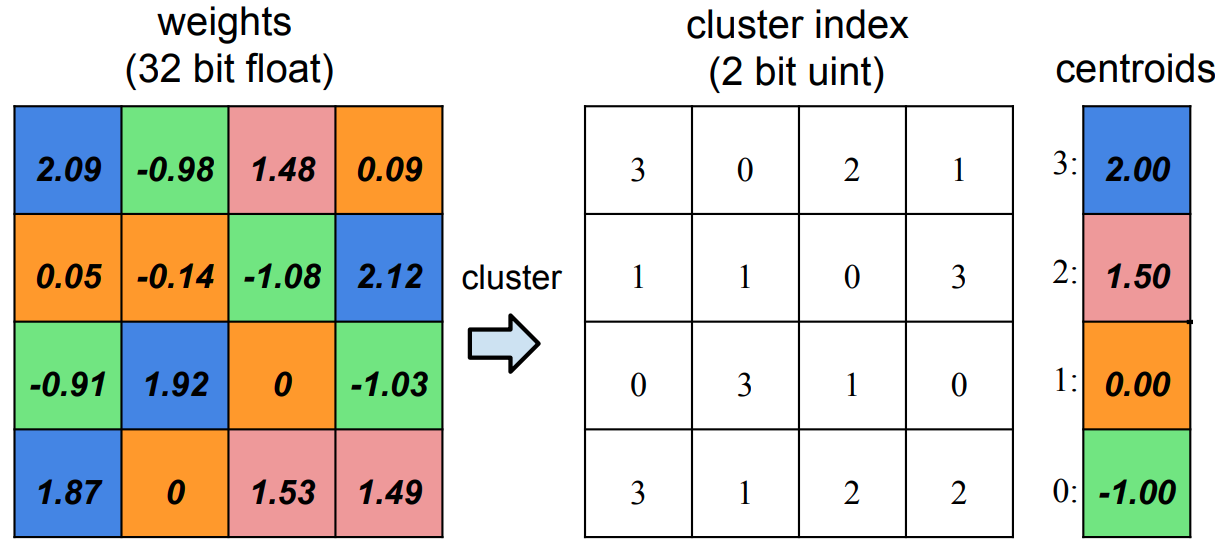


$n$-bit K-means quantization은 시냅스를 $2^n$개의 클러스터로 나누며, 동일한 클러스터에 속하는 시냅스는 동일한 가중치 값을 공유합니다.

따라서 K-means quantization은 다음을 포함하는 코드북을 생성합니다:

* centroids: $2^n$개의 FP32 클러스터들의 centroid.
* labels: 원래 FP32 가중치 텐서와 동일한 수의 요소를 가진 $n$-bit 정수 텐서. 각 정수는 해당하는 클러스터를 나타냅니다.

추론 중에, 추론용 코드북을 기반으로 fp32 텐서가 생성됩니다.

> ***quantized_weight* = *codebook.centroids*\[*codebook.labels*\].view_as(weight)**

In [ ]:
from collections import namedtuple

Codebook = namedtuple('Codebook', ['centroids', 'labels'])

# [실습 5] K-means quantization 구현

다음 K-means quantization 함수를 완성해 주세요.

In [ ]:
from fast_pytorch_kmeans import KMeans

def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        ############### YOUR CODE STARTS HERE ###############
        # bitwidth에 따라 클러스터 수를 설정하세요.
        n_clusters = 2**bitwidth
        ############### YOUR CODE ENDS HERE #################
        # k-means를 사용하여 quantization centroid를 얻습니다.
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)
        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)
    ############### YOUR CODE STARTS HERE ###############
    # 추론에서 사용할 quantized tensor를 구하기 위해 코드북을 디코딩하세요.
    quantized_tensor = codebook.centroids[codebook.labels]
    ############### YOUR CODE ENDS HERE #################
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

Define misc funcions for verification.

In [ ]:
def test_k_means_quantize(
    test_tensor=torch.tensor([
        [-0.3747,  0.0874,  0.3200, -0.4868,  0.4404],
        [-0.0402,  0.2322, -0.2024, -0.4986,  0.1814],
        [ 0.3102, -0.3942, -0.2030,  0.0883, -0.4741],
        [-0.1592, -0.0777, -0.3946, -0.2128,  0.2675],
        [ 0.0611, -0.1933, -0.4350,  0.2928, -0.1087]]),
    bitwidth=2):
    def plot_matrix(tensor, ax, title, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=-0.5, vmax=0.5, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    fig, axes = plt.subplots(1,2, figsize=(8, 12))
    ax_left, ax_right = axes.ravel()

    print(test_tensor)
    plot_matrix(test_tensor, ax_left, 'original tensor')

    num_unique_values_before_quantization = test_tensor.unique().numel()
    k_means_quantize(test_tensor, bitwidth=bitwidth)
    num_unique_values_after_quantization = test_tensor.unique().numel()
    print('* Test k_means_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        num unique values before k-means quantization: {num_unique_values_before_quantization}')
    print(f'        num unique values after  k-means quantization: {num_unique_values_after_quantization}')
    assert num_unique_values_after_quantization == min((1 << bitwidth), num_unique_values_before_quantization)
    print('* Test passed.')

    plot_matrix(test_tensor, ax_right, f'{bitwidth}-bit k-means quantized tensor', cmap='tab20c')
    fig.tight_layout()
    plt.show()

정의된 K-means quantization 함수의 기능을 확인하기 위해 더미 텐서에 위의 함수를 적용해 보겠습니다.

코드는 2-bit K-means quantization을 수행하고 quantization이전과 이후의 tensor를 보여줍니다. 각 클러스터는 고유한 색상으로 표현되며, quantized tensor에는 4개의 서로 다른 색상이 표시됩니다.

정확한 함수를 작성했다면 "Test passed." 라는 문장이 출력됩니다.

In [ ]:
test_k_means_quantize()

## 전체 모델에 대한 K-means quantization

이전 실습에서 했던 것처럼, 이제 K-means quantization 함수를 전체 모델을 양자화하기 위한 클래스로 작성합니다. KMeansQuantizer 클래스에서는 코드북(즉, centroids와 labels)을 기록하여 모델 가중치가 변경될 때마다 코드북을 적용하거나 업데이트할 수 있도록 해야 합니다.

In [ ]:
from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

이제 K-means quantization을 사용하여 모델을 8비트, 4비트 및 2비트로 quantization하겠습니다.

*코드북의 저장 공간은 모델 크기를 계산할 때 무시됩니다.*

In [ ]:
fp32_model_size = get_model_size(model)
print(f"    fp32 model의 크기={fp32_model_size/MiB:.2f} MiB")
quantizers = dict()
for bitwidth in [8,4,2]:
    recover_model()
    print(f'모델을 {bitwidth} bit로 quantization 합니다.')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model의 크기 : {quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model의 정확도 : {quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

## Quantization-aware training(QAT)

마지막 셀의 결과에서 볼 수 있듯이, 모델을 낮은 비트로 quantization할 때 정확도가 크게 떨어집니다. 따라서 정확도를 회복하기 위해 Quantization-aware training(QAT)을 수행해야 합니다.

K-means quantization-aware training 동안, centroid도 업데이트됩니다. 이는 [Deep Compression: Compressing Deep Neural Networks With Pruning, Trained Quantization
And Huffman Coding](https://arxiv.org/pdf/1510.00149.pdf)에서 제안된 방법입니다.

centroid의 gradient는 다음과 같이 계산할 수 있습니다.

> $\frac{\partial \mathcal{L} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \frac{\partial W_{j} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \mathbf{1}(I_{j}=k)$

여기서 $\mathcal{L}$ 는 loss이며, $C_k$ 는 *k*번째 centroid, $I_{j}$는 가중치 $W_{j}$에 대한 label입니다.

$\mathbf{1}()$ 는 지시함수로, 만약 $I_{j}=k\; 이라면
\;\mathbf{1}(I_{j}=k)$ 는$\;1, 아니면\;0$이 됩니다.

&nbsp;

이번 실습에서는 단순성을 위해 다음과 같이 최신 가중치에 따라 centroid를 직접 업데이트하겠습니다:

> $C_k = \frac{\sum_{j}W_{j}\mathbf{1}(I_{j}=k)}{\sum_{j}\mathbf{1}(I_{j}=k)}$

# [실습 6] Quantization Aware Training 구현

다음 코드북 업데이트 함수를 완성해 주세요.

**Hint**:

위의 centorid 업데이트 방정식은 동일한 클러스터 내에 있는 가중치들의 평균을 사용하여 centorid 값을 새로 업데이트하는 것입니다.

In [ ]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    update the centroids in the codebook using updated fp32_tensor
    :param fp32_tensor: [torch.(cuda.)Tensor]
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
    ############### YOUR CODE STARTS HERE ###############
    # hint : torch.mean() 함수를 이용하여 평균을 구할 수 있습니다.
        codebook.centroids[k] = torch.mean(fp32_tensor[codebook.labels==k])
    ############### YOUR CODE ENDS HERE #################

이제 다음 코드 셀을 실행하여 8,4,2-bit K-means quantized 모델을 fine-tune하여 정확도를 회복하겠습니다.

정확도 감소가 1%p 미만이 되면 fine-tuning을 중단합니다.

In [ ]:

def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    if extra_preprocess is not None:
        for preprocess in extra_preprocess:
            inputs = preprocess(inputs)

    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

TORCH_HUB_REPO = "SKKU-ESLAB/pytorch-models"
MODEL_NAME = "cifar10_vgg9_bn" # cifar10_resnet20, cifar10_vgg11_bn

model = torch.hub.load(TORCH_HUB_REPO, MODEL_NAME, pretrained=True)
if torch.cuda.is_available():
    model = model.cuda()

accuracy_drop_threshold = 1
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers

for bitwidth in [8,4,2]:
    recover_model()
    quantizer = KMeansQuantizer(model, bitwidth)
    print(f'모델을 {bitwidth} bit로 quantization 합니다.')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model의 크기 : {quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model의 정확도 : {quantized_model_accuracy:.2f}% before QAT ")
    accuracy_drop = fp32_model_accuracy - quantized_model_accuracy
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        정확도 감소가 {accuracy_drop:.2f}%p이므로 Quantization-aware training을 진행합니다.")
        num_finetune_epochs = 5
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        epoch = num_finetune_epochs
        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
            train(model, dataloader['train'], criterion, optimizer, scheduler,
                  callbacks=[lambda: quantizer.apply(model, update_centroids=True)])
            model_accuracy = evaluate(model, dataloader['test'])
            is_best = model_accuracy > best_accuracy
            best_accuracy = max(model_accuracy, best_accuracy)
            print(f'    Epoch {num_finetune_epochs-epoch} Accuracy {model_accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
            accuracy_drop = fp32_model_accuracy - best_accuracy
            epoch -= 1
        print(f"        정확도 감소가 {accuracy_drop:.2f}%p이므로 Quantization-aware training을 종료합니다.")
    else:
        print(f"        정확도 감소가 {accuracy_drop:.2f}%p이므로 Quantization-aware training을 종료합니다.")

# 2.3. Quantization with PyTorch API

지금까지 우리는 Quantization이 실제로 어떻게 동작하는지를 알아보기 위하여 간략화 된 모듈을 직접 작성하여 실습을 진행하였습니다.

그러나 실제로 DNN 모델에 Quantization을 적용하고 배포하는 작업은 머신 러닝 라이브러리에서 제공하는 API를 이용하는 경우가 많습니다.

이번 실습에서는 Python을 위한 오픈소스 머신 러닝 라이브러리인 PyTorch에서 지원하는 Quantization API를 사용하여 다양한 Quantization 구성을 지정하고 실제로 적용해보도록 하겠습니다.

원활한 실습을 위해 지금까지 사용한 모델보다는 조금 더 작은 크기의 모델을 새로 정의하고 초기 정확도를 측정해보겠습니다.

In [ ]:
# 모델 정의
import torch.nn.functional as F
class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()

        # 양자화 스텁 추가
        self.quant = torch.quantization.QuantStub()  # 입력을 양자화
        self.dequant = torch.quantization.DeQuantStub()  # 출력을 역양자화

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        # Pooling and Dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.quant(x)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.contiguous().view(-1, 128 * 4 * 4)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        x = self.dequant(x)
        return x

In [ ]:
!curl -L "https://github.com/SKKU-ESLAB/pytorch-models/releases/download/samsung/cifar10_model.pth" -o "D:\\data\\cifar10_model.pth"
checkpoint = torch.load('D:\\data\\cifar10_model.pth', map_location="cpu")
model = CIFAR10Classifier()
print(f"=> loading checkpoint 'cifar10_model.pth'")
model.load_state_dict(checkpoint)
recover_model = lambda : model.load_state_dict(checkpoint)

In [ ]:
# 모델 평가
original_accuracy = evaluate_model(model, testloader)
print(f"Original Model Accuracy: {original_accuracy:.2f}%")

## Post-Training Quantization

PyTorch 라이브러리를 통해 지금까지 실습한 Post-Training Quantization을 실습해보겠습니다.

PyTorch를 통한 PTQ 적용은 다음과 같은 단계로 이루어집니다.

1. **Configuration:** Per-tensor 또는 Per-channel, Symmetric 또는 Asymmetric 등 quaitzation을 위한 구성을 담은 qconfig 설정합니다.
2. **Prepare:** prepare()함수를 통해 모델에 activation과 weight의 최소값 및 최대값 관찰하기 위한 observer를 삽입합니다.
3. **Calbiration:** 데이터세트의 일부를 사용하여 추론을 진행하면서, observer가 각 activation과 weight의 최소값 및 최대값 관찰하여 기록합니다.
4. **Convert:** convert()함수를 통해 observer가 관찰한 최소값 및 최대값을 반영하여 모델에 실제 quantization을 적용합니다.

### Configuration

PyTorch에서 Quantization을 적용하기 위해서는 먼저 qconfig을 통해 Quantization의 구성을 지정해주어야 합니다.

qconfig은 weight 및 activation에 대한 quantization scheme, datatype, range를 결정하는 과정에서 사용되는 observer 등의 정보를 담고있습니다.

먼저 PyTorch에서 Quantization에서 기본적으로 사용되는 deafult_qconfig의 구성을 알아보겠습니다.

In [ ]:
# default_qconfig 로드
default_qconfig = torch.quantization.default_qconfig
qconfig_printer(default_qconfig)

PyTorch에서 Quantization에서 기본적으로 사용되는 deafult_qconfig의 구성에서는 weight에서는 Per-tensor symmetric quantization을, activation에서는 Per-tensor asymmetric quantization을 사용하여 진행하는 것을 알 수 있습니다.

PyTorch는 다음과 같은 scheme과 datatpye을 지원하고 있습니다.

#### QScheme (`torch.qscheme`): a enum that specifies the way we quantize the Tensor
- `torch.per_tensor_affine`
- `torch.per_tensor_symmetric`
- `torch.per_channel_affine`
- `torch.per_channel_symmetric`

#### dtype (`torch.dtype`): data type of the quantized Tensor
- `torch.quint8`
- `torch.qint8`
- `torch.qint32`
- `torch.float16`

### Prepare

Quantization을 위해서는 각 텐서의 값 분포를 파악하는 것이 중요합니다. 이 분포를 파악하기 위해, observer라는 특수한 모듈을 모델의 레이어에 추가합니다.
관찰자는 실행 중인 모델의 데이터를 모니터링하여 최소값과 최대값을 포함한 통계를 수집합니다. 이 정보는 나중에 데이터의 범위를 적절하게 측정하여 quatization range를 설정하기 위하여 사용됩니다.

Prepare 단계에서는 prepare()함수를 통해 모델에 activation과 weight의 최소값 및 최대값 관찰하기 위한 observer를 삽입합니다.

PyTorch는 다음과 같은 observer들을 지원하고 있습니다.

#### torch.ao.quantization.observer

- MinMaxObserver

- MovingAverageMinMaxObserver

- PerChannelMinMaxObserver

- MovingAveragePerChannelMinMaxObserver

- HistogramObserver

모델에 default qconfig과 prepare()를 적용해보고 모델 내부 모듈의 변화를 살펴보겠습니다.

In [ ]:
model.qconfig = default_qconfig
print(model)
prepared_model = torch.quantization.prepare(model, inplace=False)
print("--------------------------------------------------------------------------------------------")
print(prepared_model)

모듈 내부에 qconfig을 통해 설정 된 MinMaxobserver가 삽입된 모습을 볼 수 있습니다.

### Calibration

quantization 과정에서의 calibration 단계는 quantization된 모델이 원본 모델의 정확도를 유지할 수 있도록 observer를 사용하여 입력 데이터의 분포를 측정하는 과정입니다.

calibration 과정에서는 모델에 데이터세트의 일부를 전달하여 실행합니다. 이 데이터는 일반적으로 validation 데이터세트나 train 데이터세트에서 추출합니다.

observer는 이 데이터를 사용하여 각 레이어의 활성화와 가중치의 최소값 및 최대값을 측정합니다.

calibration을 통해 observer가 min값과 max값을 제대로 측정하였는지 관찰해보겠습니다.

In [ ]:
from copy import deepcopy

print(prepared_model)
calibrated_model = deepcopy(prepared_model)
# Calibration 수행 (첫 번째 배치로 모델에 입력 전달)
for images, _ in trainloader:
    calibrated_model(images)
    break  # Calibration을 한 번만 수행
print("--------------------------------------------------------------------------------------------")
print(calibrated_model)

Observer 모듈 내부의 min_val과 max_val이 초기값인 -inf,inf에서 적절한 값으로 변경된 것을 확인할 수 있습니다.

### Convert
convert단계에서는 convert()함수를 통해 캘리브레이션 단계에서 수집된 정보를 사용하여 각 weight를 정수로 양자화합니다.

이 과정에서 계산된 scale과 zero point가 적용되어 실제 weight 값이 정수형 텐서로 변환됩니다.

또한 원래 모델의 표준 레이어(예: nn.Conv2d, nn.Linear 등)는 그에 상응하는 quantized 버전(예: nn.quantized.Conv2d, nn.quantized.Linear 등)으로 교체됩니다.

이 교체는 모델이 효율적으로 실행될 수 있도록 하드웨어 가속을 활용하는 함수가 될 수 있습니다.

Convert()를 통해 모델이 실제로 quantized 모듈로 변경되는지 관찰해보고, 실제 quantized 된 모델을 통해 추론을 진행해보겠습니다.

In [ ]:
quantized_model = torch.quantization.convert(
    calibrated_model, inplace=False
)

print(quantized_model)
print("\n")
quantized_accuracy = evaluate_model(quantized_model, testloader)

print(f"Original model has accuracy={original_accuracy:.2f}%")
print(f"PTQ quantized model has accuracy={quantized_accuracy:.2f}%")

지금까지 PTQ기법을 통해서 PyTorch를 통해 실제로 Quantization을 진행하고 Original model과 정확도를 비교해보았습니다.

그러나 PTQ는 학습이 완료된 모델에 대해 quantization을 적용합니다. 이 과정에서 모델이 데이터의 모든 특성을 포괄적으로 학습하지 않은 상태에서 quantization을 수행하며, 또한 activation의 출력값 분포가 동적인 경우, calibration에서 얻은 scaling factor와 zero point가 모든 입력 상황에 적합하지 않을 수 있습니다. 이러한 경우 원본 모델보다 정확도 손실이 발생 할 수 있습니다.

이러한 손실을 줄이기 위해, 모델 학습 과정에서 Quantization을 시뮬레이션하고 정확도 저하를 최소화하는 방향으로 학습하는 방식인 QAT(Quantization-Aware Trainging) 이 등장하였습니다.

# Quantization-Aware Training

Quantization-Aware Training 모델의 quantization을 고려하여 이를 학습 과정에 포함시키는 방식입니다.

QAT의 목적은 훈련 단계에서부터 모델이 quantization에 따른 정보 손실을 경험하게 함으로써, 실제 quantization이 적용된 모델도 성능 저하 없이 배포될 수 있도록 하는 것입니다.

PyTorch의 Quantization API는 PTQ 뿐만 아니라 QAT 역시 지원합니다.

PyTorch를 통한 QAT 적용은 다음과 같은 단계로 이루어집니다.

## 1.Configuration
- Per-tensor 또는 Per-channel, Symmetric 또는 Asymmetric 등 quaitzation을 위한 구성을 담은 qconfig 설정합니다.
## 2.Prepare
- prepare()함수를 통해 모델에서 학습 중 quantization을 모방하여 quantization error를 시뮬레이션하는 fake quantizer를 삽입합니다.
## 3.Training
- 학습 데이터세트를 사용하여 학습을 진행하면서, fake quantizer가 quantization error를 시뮬레이션하여 loss에 반영합니다. PTQ와 다르게, QAT는 모델의 scaling factor와 zero point뿐만 아니라 모델의 weight 또한 학습합니다.
## 4.Convert
- convert()함수를 통해 fake quantizer가 학습한 caling factor와 zero point를 반영하여 모델에 실제 quantization을 적용합니다.

### Configuration

PyTorch에서 QAT를 적용하기 위해서는 먼저 qconfig을 통해 Quantization의 구성을 지정해주어야 합니다.

PTQ와 마찬가지로, qconfig은 weight 및 activation에 대한 quantization scheme, datatype 뿐만 아니라 observer 대신 fake quantizer에 대한 정보도 담고있습니다.

먼저 PyTorch에서 Quantization에서 기본적으로 사용되는 deafult_qconfig의 구성을 알아보겠습니다.

In [ ]:
# default_qconfig 로드
default_qat_qconfig = torch.quantization.default_qat_qconfig
qconfig_printer(default_qat_qconfig)

### Prepare

QAT를 위해서는 학습 중 quantization을 모방하여 quantization error를 계산하고 scale과 zero-point를 산출해내기 위한 fake quantizer가 필요합니다.

이를 위해 fake quantizer라는 모듈을 추가하여 모델 학습 중 quantization error를 수집합니다.

Prepare 단계에서는 prepare()함수를 통해 모델에 fake quantizer를 삽입합니다.

모델에 default qconfig과 prepare()를 적용해보고 모델 내부 모듈의 변화를 살펴보겠습니다.

In [ ]:
model.qconfig = default_qat_qconfig
print(model)
prepared_qat_model = torch.quantization.prepare(model, inplace=False)
print("--------------------------------------------------------------------------------------------")
print(prepared_qat_model)

모듈 내부에 qconfig을 통해 설정 된 fakequantizer가 삽입된 모습을 볼 수 있습니다.

### Training

QAT는 PTQ와 달리, calibration 단계가 아닌 training을 통해 quantization을 시뮬레이션하고 quantization error를 반영한 scale factor와 zero point를 찾고 모델의 weight또한 fine-tuning 하게 됩니다.

calibration 과정에서는 모델에 데이터세트의 일부를 전달하여 실행합니다. 이 데이터는 일반적으로 validation 데이터세트나 train 데이터세트에서 추출합니다.

observer는 이 데이터를 사용하여 각 레이어의 활성화와 가중치의 최소값 및 최대값을 측정합니다.

QAT를 위해 5epoch 동안 training을 진행한 뒤, fake quantizer가 min값과 max값을 제대로 측정하였는지 관찰해보겠습니다.

In [ ]:
from copy import deepcopy

print(prepared_qat_model)
trained_qat_model = deepcopy(prepared_qat_model)
trained_qat_model.qconfig = torch.quantization.default_qat_qconfig

trained_qat_model = train_model(trained_qat_model, trainloader, epochs=5)
print("--------------------------------------------------------------------------------------------")
print(trained_qat_model)

### Convert
마지막으로 convert단계에서는 PTQ와 마찬가지로 convert()함수를 통해 training 단계에서 수집된 정보를 사용하여 각 weight를 정수로 양자화합니다.

이 과정에서 계산된 scale과 zero point가 적용되어 실제 weight 값이 정수형 텐서로 변환됩니다.

또한 원래 모델의 표준 레이어(예: nn.Conv2d, nn.Linear 등)는 그에 상응하는 quantized 버전(예: nn.quantized.Conv2d, nn.quantized.Linear 등)으로 교체됩니다.

이 교체는 모델이 효율적으로 실행될 수 있도록 하드웨어 가속을 활용하는 함수가 될 수 있습니다.

Convert()를 통해 모델이 실제로 quantized 모듈로 변경되는지 관찰해보고, 실제 QAT를 통해 quantized 된 모델을 통해 추론을 진행해보겠습니다.

In [ ]:
qat_quantized_model = torch.quantization.convert(
    trained_qat_model, inplace=False
)

print(qat_quantized_model)
print("\n")
qat_quantized_accuracy = evaluate_model(qat_quantized_model, testloader)

print(f"Original model has accuracy={original_accuracy:.2f}%")
print(f"QAT quantized model has accuracy={qat_quantized_accuracy:.2f}%")

마지막으로, Original model과 각각 PTQ 및 QAT 방식으로 quantize 된 모델의 크기와 정확도를 비교해보겠습니다.

In [ ]:
def model_size(model):
    import os

    torch.save(model.state_dict(), "D:\\data\\model.pth")
    return os.path.getsize("D:\\data\\model.pth")

print(f"Original model has accuracy={original_accuracy:.2f}%")
print(f"PTQ quantized model has accuracy={quantized_accuracy:.2f}%")
print(f"QAT quantized model has accuracy={qat_quantized_accuracy:.2f}%")
print("--------------------------------------------------")
print(f"Original Model size: {model_size(model) / 1e6} MB")
print(f"PTQ Model size: {model_size(quantized_model) / 1e6} MB")
print(f"QAT Model size: {model_size(qat_quantized_model) / 1e6} MB")